#  Consignes pour préparation des fichiers de données<br/>et exemples lecture des données netCDF pour projet-long, filtrage, ... [vPL0]

Vous allez utiliser un programme Python qui effectue un traitement des données d’anomalies de température moyennées de l'air.  Ces données ont été calculées à l'aide modeles climatiques utilisant différents forçages, c.à.d, différents types et configurations de micro-particules ou aérosols contenus dans l’atmosphère. Le but étant d'estimer la contribution au réchauffement climatique de chacun des forçages présents. Tout comme décrit dans l'article de _Climate Informatics_ que l'on vous a envoyé. 

Les données actuellement utilisées ce sont des series temporelles, on parle aussi de profils, couvrant la période 1850-2014. La serie et composée de points et chaque point correspond à la moyenne globale pour chaque année. S’agissant d'une moyenne globale, il n'y a donc pas de distinction entre les régions de la terre, bien d'elles peuvent avoir différentes profils caractéristiques dans le réchauffement ou la variabilité climatique.

Le but de ce stage est précisément de traiter individuellement des régions du globe et comparer avec les résultats obtenues de maniere globale.

Cela-dit, dans ce Notebook, on va surtout parler de préparation des données, le sujet exacte du projet-long vous le affinerez lors des discutions avec vos encadreurs.

<br/>

Notebook: `Consignes_prepar_donnees_et_lect_nc_pour_pl_vPL0.ipynb`

C.Mejia, LOCEAN/IPSL - 24 Fev. 2023

___
## Description sommaire des fichiers source

Les données extraites sont ici:

    /Users/carlos/Clouds/SUnextCloud/Labo/Travaux/Theses-et-stages/These_Constantin/constantin_data/data_source/Projet-court-2022-2023/

Elles sont dans des fichiers au format NetCDF, avec un fichier par forçage et par modèle. A l’intérieur des NetCDF, les différents membres apparaissent comme des time-séries avec des noms de variable différents, comme par exemple `tas_r1i1p1f1_ano`.

Les données sont des séries temporelles brutes (sans lissage ou filtre appliqué) couvrant la période 1850-2014, dont la moyenne de la simulation préindustrielle à été enlevé. Il s’agit donc d’anomalies de température par rapport à la période préindustrielle (avant 1850).

Dans les fichiers, il y a une dimension `region` impliquant un numero de région (il y a 58 régions au choix), et une dimension `time` donnant le temps, l'année en fait car il s'agit des moyennes annuelles. Il y a 165 années.

Les régions sont définis comme AR6 Regions. Voir figure ou bien dans la page suivante:
https://regionmask.readthedocs.io/en/stable/defined_scientific.html

<img align="center"
     src="Images/plotting_ar6_all.png"
     alt="AR6 Regions"
     title="AR6 Regions"
     style="display:block;float:none;margin-left:auto;margin-right:auto;width:70%">

Je suggère de choisir les régions 48 (Pacifique équatorial) et 50 (Atlantique Nord) pour les 2 projets.

## Préparation des données de base

A partir des données NetCDF mentionnées ci-dessus, vous devez préparer plusieurs fichiers des données par zone d’étude.

_Note:_ Vous trouverez plus bas dans ce Notebook, des exemples de comment lire les fichier NetCDF avec `xarray` et comment en extraire les infos qui nous intéressent de ces fichiers.

### Fichiers nécessaires au programme

L'application actuelle nécessite un certain nombre de fichiers respectant une structure precise pour bien les intégrer au programme.

Les profils doivent être copiées dans des fichiers par type de forçage (`GHG`, `AER`, `NAT` et `HIST`) et doivent être accompagnés de fichiers de base indiquant la structure des données. Voici quelques explications:

#### Fichiers de structure

Vous devez en première instance créer au moins les deux fichiers de base représentant la structure des données disponibles.  Il faudrait les nommer de la façon suivante: `'ALL_sim_zXXvY.p'` et `'models_zXXvY.p'` où `XX` represente le numéro de zone (48, 50, ...) et `Y` c'est le numero de version des données que vous générerez, commencez par 0 , par exemple (donc `'ALL_sim_z48v0.p'` et `'models_z48v0.p'`, ...). Vous incrémenterez s’il est nécessaire d'en creer des versions supplémentaires.

Voici en exemple le contenu des fichiers de base actuellement utilisées pour expliquer ce que doivent contenir ces fichiers :

 - Fichier `'ALL_sim_v4.p'`: Ce fichier contient une tableau aux dimensions (nb_forcings, nb_models) contenant **le nombre de profils que l'on a pour chaque modèle et chaque forçage**, les modeles par colonne et les forçages par ligne. Notons ce tableau, un array `numpy`, par `all_sim`.  Voici le contenu de `'ALL_sim_v4.p'`:

       [[   3    3   50   10    3   10    3    4    5   10    3    3    1]
        [   3    3   30   10    3   10   10    4    5   15    2    3    1]
        [   3    3   50   10    3   10   44    4    5   20    3    3    3]
        [   3    6   65   30   40   33   50    5   11   35   11    3    3]
        [ 600  700 1000  500  500 1000  500  500  500  851  500  110  500]]
        
_Note:_ pour ces données globales, il y avait une cinquième ligne de forçages que nous n'aurons pas avec les nouvelles données par zone. Nos fichiers par zone devraient avoir une ligne en moins.

 - Fichier `'models_v4.p'`: Contiene simplement la liste de modèles participant aux données, dans l'ordre des colonnes du tableau dans `'ALL_sim_v4.p'`.  Voici son contenu :

       ['BCC-CSM2-MR', 'FGOALS-g3', 'CanESM5', 'CNRM-CM6-1', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC6', 'HadGEM3-GC31-LL', 'MRI-ESM2-0', 'GISS-E2-1-G', 'CESM2', 'NorESM2-LM', 'GFDL-ESM4']
        

 - Il y a aussi les labels des forçages dans l’ordre correspondant aux lignes dans `'ALL_sim_v4.p'`. Cette liste ne vient pas proprement d’un fichier mais vous pouvez en créer un `'forcings_zXXvY.p’`.  Ainsi, on evite qu'il n'y ait de doute quant à l'ordre de lignes du tableau. Dans le cas des données globales l’ordre de lignes est: 

     ['ghg', 'aer', 'nat', 'hist', 'other']
     
##### _Modification éventuelle_:

Actuellement ces fichiers sont sauvés en array ou listes brutes dans les fichiers `picole`. Vous pouvez modifier la sauvegarde pour sauver dans un seul fichier un DataFrame `pandas` à la place des trois fichiers `'ALL_sim_zXXvY.p'`,  `'models_zXXvY.p'` et `'forcings_zXXvY.p'`.  Le DataFrame aurait par exemple les noms des modeles comme nom des colonnes et les noms des forçages en index, ou bien une colonne supplémentaire avec ne nom du forçage.

Si vous optez pour cela, que je vous recommande, il y aurait des petites modification à faire dans le code du chargement des données, au moins, de mémoire, dans la fonction `load_basic_data_and_gener_df` du fichier `generic_tools.py`. Et aussi vérifier dans le code partout chaque appel à cette fonction pour que les arguments soient cohérents aux changements effectués.

#### Fichiers des données source

Les données à utiliser par le programme devront être générées dans une ultérieure préparation en les classiques ensembles `APP`, `TEST` et `VAL`. Cela pourra se faire à partit des tableaux de données source que vous devez préparer d'abord.

Le données source ce sont concentrées dans 4 fichiers, un pour chaque type de forçage `GHG`, `AER`, `NAT` et `HIST`, contenant l’intégralité des profiles trouvés dans les fichiers NetCDF du répertoire d'extraction.

Chaque fichier contiendra alors tous les profils du même forçage pour tous les modeles climatiques dans le même ordre des colonnes de `all_sim`. A la base, ces fichiers ne contiennent pas des DataFrame ou Dataset, ils contiennent tout juste un _array_ `numpy` de taille $[N_{(i)} \times 165]$ ou $N_{(i)}$ est le nombre de profils du _i_-eme forçage et 165 le nombre d’années. Ces $N_{(i)}$ sont en fait la somme des éléments de la _i_-eme ligne de `all_sim`. 

Vous devez générer les quatre fichiers  `’T_ghg_zXXvY.p'`,  `’T_aer_zXXvY.p'`,  `’T_nat_zXXvY.p'` et  `’T_hist_zXXvY.p’`.

A noter que les profils des forçages `GHG` et  `AER` doivent être filtrés pour retirer les composantes haute fréquence du signal.  Dans le programme il y a la possibilité de filtrer également les forçages `NAT` et  `HIST` selon les expériences que l’on souhaite réaliser, mais les profils `GHG` et  `AER` doivent toujours être filtrés. Pour cela il faut le faire pour la préparation des fichiers source. 

Pour le filtrage on utilise la méthode `signal.butter()` et `signal.filtfilt()` du module Python `scipy`.  Dans notre librairie de fonctions nous avons `filter_forcing_df()` dans `generic_tools.py` qui fait ce filtrage, mais la fonction le fait sur une suite de données présente dans un DataFrame `pandas`.  Un exemple de filtrage utilisant cette fonction est illustré dans ce Notebook.


### Génération des ensembles pour l’entrainement  `APP`, `TEST`, `VAL` et même pour l’Inversion

Les données qui seront utilisés pour l'entrainement et inversions des profils sont composées d'une entrée _X_ composée de trois forçages `GHG`, `AER` et `NAT` associées à une sortie _Y_ avec un profile `HIST`. La composition des ensembles de données pour l'entrainement est donc une affaire de combinaisons des forçages.

Lisez en particulier dans l'entête du Notebook `generate_TRAIN-TEST_data_sets_to_DF_Nb0.ipynb` la partie **Conditions pour former les ensembles de données TRAIN et TEST** qu'explique la formations des ces ensembles et les combinaisons évitant un tant soit peu les répétitions de combinaisons entre les ensembles.

Notez qu'il y a aussi le Notebook `generate_INVERSION_data_sets_to_DF_Nb0.ipynb` qui comme son nom l'indique vous sera utile pour générer un ensemble destiné à l'inversion des profils Historiques.

In [2]:
#from climaf.api import *

import os, glob, sys
import numpy as np
#import pickle
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import seaborn as sns

from scipy import signal

#clog('critical') 
import re

# To load personal libraries (currently in folder 'tools'):
sys.path.append('tools')

import generic_tools_pl as gt   # like hexcolor(), ...


In [2]:
def sort_human(l):
    """ fonction de trie des labels alpha-numériques. Utile pour trier correctement des labels
        du style [ 'r1i', 'r2i', 'r7i', 'r10i' ]
        
        Avec un tri classique on va obtenir ['r10i', 'r1i', 'r2i', 'r7i'],

        Mais avec sort_human() on aura ['r1i', 'r2i', 'r7i', 'r10i'], respectant l'ordre
        numérique de l'indice entre le 'r' et le 'i'.
        
        Ce procédé de trie est utile pour trier les noms des variables qui ont des noms comme
        'tas_r1i1p1f1_ano', 'tas_r11i1p1f1_ano' ou encore 'tas_r5i1p1f4_ano'. Tous les indices
        numériques peuvent varier et cette fonction preserve l'ordre du tri dans un sens
        logique.
    """
    convert = lambda text: float(text) if text.isdigit() else text
    alphanum = lambda key: [convert(c) for c in re.split('([-+]?[0-9]*\.?[0-9]*)', key)]
    l.sort(key=alphanum)
    return l

In [3]:
#!ls -l ..
!ls -l ../region48 | head
#!ls -l ../../constantin_data/data_source/Projet-court-2022-2023

total 3992
-rw-r--r--@ 1 dahmani  staff   17446 Mar  1 13:34 ACCESS-ESM1-5_hist-GHG_Reg_zone48.nc
-rw-r--r--@ 1 dahmani  staff   17446 Mar  1 13:34 ACCESS-ESM1-5_hist-aer_Reg_zone48.nc
-rw-r--r--@ 1 dahmani  staff   17446 Mar  1 13:34 ACCESS-ESM1-5_hist-nat_Reg_zone48.nc
-rw-r--r--@ 1 dahmani  staff   45486 Mar  1 13:34 ACCESS-ESM1-5_historical_Reg_zone48.nc
-rw-r--r--@ 1 dahmani  staff   17446 Mar  1 13:34 BCC-CSM2-MR_hist-GHG_Reg_zone48.nc
-rw-r--r--@ 1 dahmani  staff   17446 Mar  1 13:34 BCC-CSM2-MR_hist-aer_Reg_zone48.nc
-rw-r--r--@ 1 dahmani  staff   17446 Mar  1 13:34 BCC-CSM2-MR_hist-nat_Reg_zone48.nc
-rw-r--r--@ 1 dahmani  staff   17446 Mar  1 13:34 BCC-CSM2-MR_historical_Reg_zone48.nc
-rw-r--r--@ 1 dahmani  staff   16834 Mar  1 13:34 CESM2_hist-GHG_Reg_zone48.nc


### Repertoire des données

In [1]:
data_dir = '../Projet-long-2022-2023'

In [5]:
# Exemple de lecture en Dataset (xarray) du fichier NetCDF des profils d’anomalies de température de l'air
# du forcage GHG pour le modele climatique 'ACCESS-ESM1-5'

forcings_filename = 'ACCESS-ESM1-5_hist-GHG_Reg_zone48.nc'

model_name = forcings_filename.strip('_hist-GHG_Reg.nc')

print(f"Lecture des donnees pour PL - fichier: '{forcings_filename}':")
profilsT_ghg_ds = xr.open_dataset(os.path.join(data_dir,forcings_filename))
profilsT_ghg_ds

Lecture des donnees pour PL - fichier: 'ACCESS-ESM1-5_hist-GHG_Reg_zone48.nc':


<xarray.Dataset>
Dimensions:           (time: 165)
Coordinates:
    height            float64 ...
  * time              (time) datetime64[ns] 1850-07-01T06:00:00 ... 2014-07-0...
    region            int64 ...
    abbrevs           object ...
    names             object ...
Data variables:
    tas_r1i1p1f1_ano  (time) float64 ...
    tas_r2i1p1f1_ano  (time) float64 ...
    tas_r3i1p1f1_ano  (time) float64 ...

In [7]:
regions = 48

nrows=1
ncols=len(regions)

# plot pour une seule region (48) les profils pour chaque membre, un par un 
bottom = 0.05; top    = 0.90
left   = 0.07; right  = 0.98
wspace = 0.05; hspace = 0.05
fig,axes = plt.subplots(nrows=nrows,ncols=ncols,sharex=True,sharey=True,figsize=(14,4),
                        gridspec_kw={'hspace': hspace, 'wspace': wspace, 
                                     'left': left,     'right': right,
                                     'top' : top,      'bottom' : bottom })

# liste de variables du Dataset
list_nc_var = list(profilsT_ghg_ds.keys())

for ax,n_region in zip(axes,regions) :
    for var in list_nc_var :
        hh=profilsT_ghg_ds[var].isel(region=n_region).plot(ax=ax, x='time',label=var) #f"GHG region({n_region})")
        #print(hh[0].axes.get_title())
    ax.set_ylabel('')
    ax.set_title(f"Membres pour forcage GHG en region {n_region}",size='medium')
    ax.legend()
    # ajoute ligne ordonnee zero
    xlim=ax.get_xlim(); ax.hlines(0,xmin=xlim[0],xmax=xlim[1],color='k',lw=0.5); ax.set_xlim(xlim);

plt.suptitle(f"Membres du modele {model_name} pour GHG dans les regions en etude", size='x-large', y=1.0);

TypeError: object of type 'int' has no len()

### _Exemple de filtrage "low-pass"_

Utilisation d'une fonction de filtrage "pass bas" pour retirer le "bruit" hautes fréquences.

### _conversion en DataFrame_

Pour le filtrage on utilise la méthode `signal.butter()` et `signal.filtfilt()` du module Python `scipy`.

Dans notre librairie de fonction nous avons `filter_forcing_df()` qui fait ce filtrage mais sur une suite de données dans un DataFrame `pandas`. 

Voici un exemple de conversion du Dataset `xarray` en DataFrame `pandas` pour "nettoyer" les données en vue du filtrage. On le fait pour une seule variable `'tas_r1i1p1f1_ano'` et en sélectionnant la zone `48` à filtrer.

Puis, on retire les colonnes inutiles pour le filtrage et on transpose à la fin.

In [8]:
# exemple 
profilsT_ghg_df = profilsT_ghg_ds.to_dataframe(dim_order=['region','time'])

profilsT_ghg_df


ValueError: dim_order ['region', 'time'] does not match the set of dimensions of this Dataset: ['time']

In [8]:
# Conversion du Dataset `xarray` en DataFrame `pandas` pour "nettoyer" les données en vue du filtrage.
# On le fait pour une seule variable `'tas_r1i1p1f1_ano'` et en sélectionnant la zone `48` à filtrer.
#
#Puis, on retire les colonnes inutiles pour le filtrage et on transpose à la fin.

T_ghg_df = profilsT_ghg_ds['tas_r1i1p1f1_ano'].isel(region=48).to_dataframe(dim_order=None).drop(columns=['height', 'region', 'abbrevs','names']).T
T_ghg_df


time,1850-07-01 06:00:00,1851-07-01 06:00:00,1852-07-01 06:00:00,1853-07-01 06:00:00,1854-07-01 06:00:00,1855-07-01 06:00:00,1856-07-01 06:00:00,1857-07-01 06:00:00,1858-07-01 06:00:00,1859-07-01 06:00:00,...,2005-07-01 06:00:00,2006-07-01 06:00:00,2007-07-01 06:00:00,2008-07-01 06:00:00,2009-07-01 06:00:00,2010-07-01 06:00:00,2011-07-01 06:00:00,2012-07-01 06:00:00,2013-07-01 06:00:00,2014-07-01 06:00:00
tas_r1i1p1f1_ano,0.437182,0.028697,-0.13289,-1.233601,0.100446,-0.244363,0.339896,-0.27608,0.560602,0.906116,...,1.570628,0.595394,0.78781,1.554385,1.275888,1.510629,1.722107,1.376684,1.043598,1.044848


In [9]:
lp_obs_filtering_dic = { 'n':4, 'Wn':[1./10.], 'btype':'lowpass' }

print(f" 2- low-pass filtering this base Obs profile ...")
filter_T_ghg_df = gt.filter_forcing_df(T_ghg_df, filt_dic=lp_obs_filtering_dic, verbose=False)


 2- low-pass filtering this base Obs profile ...


<AxesSubplot:xlabel='time'>

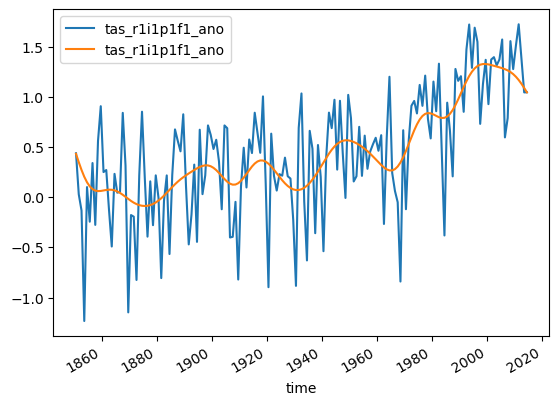

In [10]:
_,ax = plt.subplots(nrows=1, ncols=1)
T_ghg_df.T.plot(ax=ax)
filter_T_ghg_df.T.plot(ax=ax)


### _Une autre manière de convetir en DataFrame ..._

,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,0.437182,0.028697,-0.13289,-1.233601,0.100446,-0.244363,0.339896,-0.27608,0.560602,0.906116,...,1.570628,0.595394,0.78781,1.554385,1.275888,1.510629,1.722107,1.376684,1.043598,1.044848


,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,0.431712,0.348646,0.271168,0.203422,0.148339,0.107325,0.08021,0.065426,0.060372,0.061873,...,1.28471,1.274852,1.26254,1.246546,1.225753,1.199389,1.167242,1.129778,1.08815,1.044075


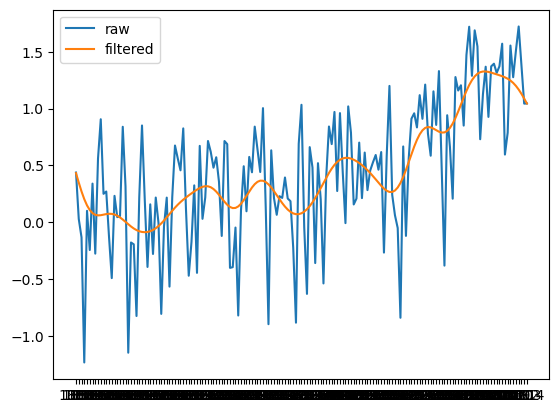

In [11]:
# conversion de la date du Dataset en annee ...
years = [ pd.to_datetime(str(t)).strftime('%Y') for t in profilsT_ghg_ds['time'].values.flatten() ]
data = np.expand_dims(profilsT_ghg_ds['tas_r1i1p1f1_ano'].isel(region=48).values,axis=0)

# creation du DataFrame
df = pd.DataFrame(data=data, columns=years)
display(df)

# filtrage
fdf = gt.filter_forcing_df(df, filt_dic=lp_obs_filtering_dic, verbose=False)
display(fdf)

# plot a la manière matplotlib directe ...
plt.plot(df.columns, df.values.T, label='raw')
plt.plot(fdf.columns, fdf.values.T, label='filtered')
plt.legend()

### _Obtention de la liste de modeles ..._

In [5]:
# liste de modeles climatiques, triée par ordre alphabetique
all_models = []
all_nc_files = np.sort(glob.glob(os.path.join(data_dir,'*_hist-GHG_Reg.nc')))

for f in np.sort(all_nc_files):
    basename = os.path.basename(f)
    #fname = basename.strip('_hist-GHG_Reg.nc')  # retire '_hist-GHG_Reg.nc' au nom de chaque fichier pour ne garder que le nom du modele climatique
    fname = basename.split('_')[0]  # prend le premier decoupage du nom du fichier, decoupant par '_', et qui correspond au nom du modele
    print(f,os.path.basename(f),fname)
    all_models.append(fname)

print(f"{len(all_models)} models found:\n {all_models}")


../Projet-long-2022-2023/ACCESS-ESM1-5_hist-GHG_Reg.nc ACCESS-ESM1-5_hist-GHG_Reg.nc ACCESS-ESM1-5
../Projet-long-2022-2023/BCC-CSM2-MR_hist-GHG_Reg.nc BCC-CSM2-MR_hist-GHG_Reg.nc BCC-CSM2-MR
../Projet-long-2022-2023/CESM2_hist-GHG_Reg.nc CESM2_hist-GHG_Reg.nc CESM2
../Projet-long-2022-2023/CNRM-CM6-1_hist-GHG_Reg.nc CNRM-CM6-1_hist-GHG_Reg.nc CNRM-CM6-1
../Projet-long-2022-2023/CanESM5_hist-GHG_Reg.nc CanESM5_hist-GHG_Reg.nc CanESM5
../Projet-long-2022-2023/FGOALS-g3_hist-GHG_Reg.nc FGOALS-g3_hist-GHG_Reg.nc FGOALS-g3
../Projet-long-2022-2023/GISS-E2-1-G_hist-GHG_Reg.nc GISS-E2-1-G_hist-GHG_Reg.nc GISS-E2-1-G
../Projet-long-2022-2023/HadGEM3-GC31-LL_hist-GHG_Reg.nc HadGEM3-GC31-LL_hist-GHG_Reg.nc HadGEM3-GC31-LL
../Projet-long-2022-2023/IPSL-CM6A-LR_hist-GHG_Reg.nc IPSL-CM6A-LR_hist-GHG_Reg.nc IPSL-CM6A-LR
../Projet-long-2022-2023/MIROC6_hist-GHG_Reg.nc MIROC6_hist-GHG_Reg.nc MIROC6
../Projet-long-2022-2023/MRI-ESM2-0_hist-GHG_Reg.nc MRI-ESM2-0_hist-GHG_Reg.nc MRI-ESM2-0
../Projet-lon

### _Exemple de lecture du forcage GHG pout tous les modeles ..._


In [6]:
# Exemple de lecture du forcage GHG ...
#  Lecture des profils d’anomalies de température de l'air, forcage GHG, pour tous les modeles

all_forcings = ['GHG', 'AER', 'NAT', 'HIST']
all_forc_file_ext = ['hist-GHG', 'hist-aer', 'hist-nat', 'historical']

print(f"Modeles et nombre de membres par forcage:")

for model_name in all_models:
    print(f" {model_name:16}",end='')
    for foncing,forc_in_fname in zip(all_forcings,all_forc_file_ext):
        forcings_filename = f'{model_name}_{forc_in_fname}_Reg.nc'
        
        profilsT_ds = xr.open_dataset(os.path.join(data_dir,forcings_filename))
        
        # comment savoir quelles variables de données dans le Dataset ?
        # c'est aussi la liste de membres du même forcage pour le modele en question
        list_nc_var = list(profilsT_ds.keys())
        #list_nc_var = sort_human(list(profilsT_ds.keys()))
        
        # Pour affichage:
        if False:
            print(f" {foncing:5} {len(list_nc_var):2d}",end='')
        else:
            print(f"\n - {model_name:16s}, Forcing: {foncing:5}",end='')
            print(f"   - Liste de {len(list_nc_var)} membres trouvees dans le Dataset:\n     {list_nc_var}",end='')
            for nc_var in list_nc_var :
                print(f"\n   - Member: {nc_var}, regions: {profilsT_ds[nc_var].shape[1]}, years: {profilsT_ds[nc_var].shape[0]}",end='')
                for n_region in [48, 50] :
                    rsim_da = profilsT_ds[nc_var].isel(region=n_region)
                    print(f" - Reg: {n_region}, size: {rsim_da.shape}",end='')
        
        #del(profilsT_ds)
    print()

Modeles et nombre de membres par forcage:
 ACCESS-ESM1-5   
 - ACCESS-ESM1-5   , Forcing: GHG     - Liste de 3 membres trouvees dans le Dataset:
     ['tas_r1i1p1f1_ano', 'tas_r2i1p1f1_ano', 'tas_r3i1p1f1_ano']
   - Member: tas_r1i1p1f1_ano, regions: 58, years: 165 - Reg: 48, size: (165,) - Reg: 50, size: (165,)
   - Member: tas_r2i1p1f1_ano, regions: 58, years: 165 - Reg: 48, size: (165,) - Reg: 50, size: (165,)
   - Member: tas_r3i1p1f1_ano, regions: 58, years: 165 - Reg: 48, size: (165,) - Reg: 50, size: (165,)
 - ACCESS-ESM1-5   , Forcing: AER     - Liste de 3 membres trouvees dans le Dataset:
     ['tas_r1i1p1f1_ano', 'tas_r2i1p1f1_ano', 'tas_r3i1p1f1_ano']
   - Member: tas_r1i1p1f1_ano, regions: 58, years: 165 - Reg: 48, size: (165,) - Reg: 50, size: (165,)
   - Member: tas_r2i1p1f1_ano, regions: 58, years: 165 - Reg: 48, size: (165,) - Reg: 50, size: (165,)
   - Member: tas_r3i1p1f1_ano, regions: 58, years: 165 - Reg: 48, size: (165,) - Reg: 50, size: (165,)
 - ACCESS-ESM1-5   ,

In [13]:
profilsT_ds

<xarray.Dataset>
Dimensions:           (time: 165)
Coordinates:
    height            float64 ...
  * time              (time) object 1850-07-01 06:00:00 ... 2014-07-01 06:00:00
    region            int64 ...
    abbrevs           object ...
    names             object ...
Data variables:
    tas_r1i1p1f1_ano  (time) float64 ...
    tas_r2i1p1f1_ano  (time) float64 ...
    tas_r3i1p1f1_ano  (time) float64 ...

In [14]:
# sur la derniere valeur du Dataset profilsT_ds dans la boucle, on plot pour le premier membre (list_nc_var[0]) le profils de chaque region 
profilsT_ds[list_nc_var[0]].plot(x='time',col='region', col_wrap=9, aspect=1.2, size=1.6, add_legend=False);
plt.suptitle(f"All regions found in file {forcings_filename}", size='x-large', y=1.01)

ValueError: IndexVariable objects must be 1-dimensional